<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/14_2_Resnet_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 15.0 MB/s 
     |████████████████████████████████| 1.3 MB 62.4 MB/s 
     |████████████████████████████████| 4.9 MB 65.1 MB/s 
     |████████████████████████████████| 365 kB 75.4 MB/s 
     |████████████████████████████████| 212 kB 60.4 MB/s 
     |████████████████████████████████| 115 kB 74.9 MB/s 
     |████████████████████████████████| 120 kB 77.0 MB/s 
     |████████████████████████████████| 127 kB 76.6 MB/s 
     |████████████████████████████████| 6.6 MB 53.2 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# ResNets

In this chapter, we will build on top of the CNNs introduced in the previous chapter and explain to you the ResNet (residual network) architecture. It was introduced in 2015 by Kaiming He et al. in the article "Deep Residual Learning for Image Recognition" and is by far the most used model architecture nowadays. More recent developments in image models almost always use the same trick of residual connections, and most of the time, they are just a tweak of the original ResNet.

We will first show you the basic ResNet as it was first designed, then explain to you what modern tweaks make it more performant. But first, we will need a problem a little bit more difficult than the MNIST dataset, since we are already close to 100% accuracy with a regular CNN on it.

#Going Back to Imagenette

It's going to be tough to judge any improvements we make to our models when we are already at an accuracy that is as high as we saw on MNIST in the previous chapter, so we will tackle a tougher image classification problem by going back to Imagenette. We'll stick with small images to keep things reasonably fast.

Let's grab the data—we'll use the already-resized 160 px version to make things faster still, and will random crop to 128 px:

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

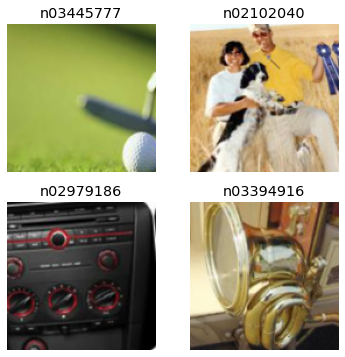

In [5]:
dls.show_batch(max_n=4)

When we looked at MNIST we were dealing with 28×28-pixel images. For Imagenette we are going to be training with 128×128-pixel images. Later, we would like to be able to use larger images as well—at least as big as 224×224 pixels, the ImageNet standard. Do you recall how we managed to get a single vector of activations for each image out of the MNIST convolutional neural network?

The approach we used was to ensure that there were enough stride-2 convolutions such that the final layer would have a grid size of 1. Then we just flattened out the unit axes that we ended up with, to get a vector for each image (so, a matrix of activations for a mini-batch). We could do the same thing for Imagenette, but that would cause two problems:

We'd need lots of stride-2 layers to make our grid 1×1 at the end—perhaps more than we would otherwise choose.
The model would not work on images of any size other than the size we originally trained on.
One approach to dealing with the first of these issues would be to flatten the final convolutional layer in a way that handles a grid size other than 1×1. That is, we could simply flatten a matrix into a vector as we have done before, by laying out each row after the previous row. In fact, this is the approach that convolutional neural networks up until 2013 nearly always took. The most famous example is the 2013 ImageNet winner VGG, still sometimes used today. But there was another problem with this architecture: not only did it not work with images other than those of the same size used in the training set, but it required a lot of memory, because flattening out the convolutional layer resulted in many activations being fed into the final layers. Therefore, the weight matrices of the final layers were enormous.

This problem was solved through the creation of fully convolutional networks. The trick in fully convolutional networks is to take the average of activations across a convolutional grid. In other words, we can simply use this function:

In [6]:
def avg_pool(x): return x.mean((2,3))

As you see, it is taking the mean over the x- and y-axes. This function will always convert a grid of activations into a single activation per image. PyTorch provides a slightly more versatile module called nn.AdaptiveAvgPool2d, which averages a grid of activations into whatever sized destination you require (although we nearly always use a size of 1).

A fully convolutional network, therefore, has a number of convolutional layers, some of which will be stride 2, at the end of which is an adaptive average pooling layer, a flatten layer to remove the unit axes, and finally a linear layer. Here is our first fully convolutional network:

In [7]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

We're going to be replacing the implementation of block in the network with other variants in a moment, which is why we're not calling it conv any more. We're also saving some time by taking advantage of fastai's ConvLayer, which that already provides the functionality of conv from the last chapter (plus a lot more!).

!!! REMEMBER : Fully convolutional networks are only really a good choice for objects that don't have a single correct orientation or size (e.g., like most natural photos).

Once we are done with our convolutional layers, we will get activations of size bs x ch x h x w (batch size, a certain number of channels, height, and width). We want to convert this to a tensor of size bs x ch, so we take the average over the last two dimensions and flatten the trailing 1×1 dimension like we did in our previous model.

This is different from regular pooling in the sense that those layers will generally take the average (for average pooling) or the maximum (for max pooling) of a window of a given size. For instance, max pooling layers of size 2, which were very popular in older CNNs, reduce the size of our image by half on each dimension by taking the maximum of each 2×2 window (with a stride of 2).

As before, we can define a Learner with our custom model and then train it on the data we grabbed earlier:

In [8]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(valley=0.0014454397605732083)

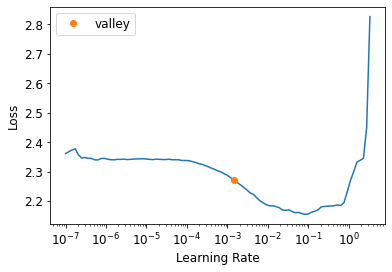

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.880449,2.586634,0.323567,00:28
1,1.508486,1.364545,0.559490,00:26
2,1.289859,1.326966,0.560510,00:26
3,1.120919,1.119277,0.644331,00:27
4,1.025062,1.047488,0.669809,00:26


That's a pretty good start, considering we have to pick the correct one of 10 categories, and we're training from scratch for just 5 epochs! We can do way better than this using a deeper mode, but just stacking new layers won't really improve our results (you can try and see for yourself!). To work around this problem, ResNets introduce the idea of skip connections. We'll explore those and other aspects of ResNets in the next section.

# Building a Modern CNN: ResNet

We now have all the pieces we need to build the models we have been using in our computer vision tasks since the beginning of this book: ResNets. We'll introduce the main idea behind them and show how it improves accuracy on Imagenette compared to our previous model, before building a version with all the recent tweaks.

# Skip Connections

In 2015, the authors of the ResNet paper noticed something that they found curious. Even after using batchnorm, they saw that a network using more layers was doing less well than a network using fewer layers—and there were no other differences between the models. Most interestingly, the difference was observed not only in the validation set, but also in the training set; so, it wasn't just a generalization issue, but a training issue. As the paper explains:

*Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error, as [previously reported] and thoroughly verified by our experiments.*

As the authors mention here, they are not the first people to have noticed this curious fact. But they were the first to make a very important leap:

*Let us consider a shallower architecture and its deeper counterpart that adds more layers onto it. There exists a solution by construction to the deeper model: the added layers are identity mapping, and the other layers are copied from the learned shallower model*

In other words, they suggest to tart with a 20-layer neural network that is trained well, and add another 36 layers that do nothing at all (for instance, they could be linear layers with a single weight equal to 1, and bias equal to 0). The result will be a 56-layer network that does exactly the same thing as the 20-layer network, proving that there are always deep networks that should be at least as good as any shallow network. But for some reason, SGD does not seem able to find them.

Actually, there is another way to create those extra 36 layers, which is much more interesting. What if we replaced every occurrence of conv(x) with x + conv(x), where conv is the function from the previous chapter that adds a second convolution, then a batchnorm layer, then a ReLU. Furthermore, recall that batchnorm does gamma*y + beta. What if we initialized gamma to zero for every one of those final batchnorm layers? Then our conv(x) for those extra 36 layers will always be equal to zero, which means x+conv(x) will always be equal to x.

What has that gained us? The key thing is that those 36 extra layers, as they stand, are an identity mapping, but they have parameters, which means they are trainable. So, we can start with our best 20-layer model, add these 36 extra layers which initially do nothing at all, and then fine-tune the whole 56-layer model. Those extra 36 layers can then learn the parameters that make them most useful.The ResNet paper actually proposed a variant of this, which is to instead "skip over" every second convolution, so effectively we get x+conv2(conv1(x)) as follows:

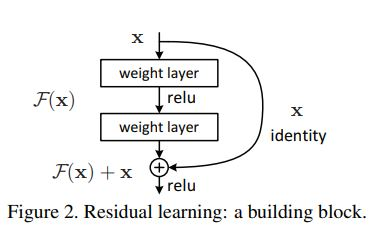

That arrow on the right is just the x part of x+conv2(conv1(x)), and is known as the identity branch or skip connection. The path on the left is the conv2(conv1(x)) part. You can think of the identity path as providing a direct route from the input to the output.

In a ResNet, we don't actually proceed by first training a smaller number of layers, and then adding new layers on the end and fine-tuning. Instead, we use ResNet blocks throughout the CNN, initialized from scratch in the usual way, and trained with SGD in the usual way. We rely on the skip connections to make the network easier to train with SGD.

There's another (largely equivalent) way to think of these ResNet blocks. This is how the paper describes it: